## Image Recognition with Fashion

#### Waylon Abernathy

#### Big Data

#### 12/2/19

In [365]:
import os
import struct
import numpy as np
import pandas

import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno


### Load Dataset

We'll be working with two different types of datasets.  Each contain the Fashion MNIST data images; however, the two datasets are in different formats to accomodate the various types of classifying approaches.  

In [366]:
# MIGHT NEED TO CHANGE PATH BASED ON HOW YOU EXTRACT MNIST
# THIS FILE ADDS *-labels DOT idx*-ubyte TO PATH
def load_trmnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' 
                                % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' 
                               % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [367]:
# MIGHT NEED TO CHANGE PATH BASED ON HOW YOU EXTRACT MNIST
# THIS FILE ADDS *-labels DOT idx*-ubyte TO PATH
def load_temnist(path, kind='t10k'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' 
                                % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' 
                               % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [368]:
X_test, y_test = load_temnist('/Users/wa3/Syracuse/Term5/BigData/HW3', kind='t10k')

In [369]:
X_train, y_train = load_trmnist('/Users/wa3/Syracuse/Term5/BigData/HW3', kind='train')

#### Check Data Deminsions

In [370]:
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))


Rows: 60000, columns: 784


In [371]:
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


### Visualtion of Images

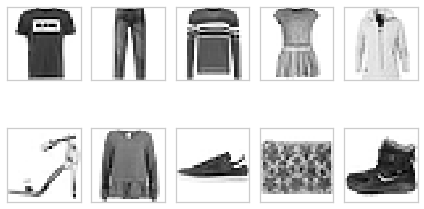

In [372]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

plt.show()

The images above show how we may have difficulty classifying certain types of clothing.  Many of the different categories of upper wear look very similar in shape and will likely utilize the same number of pixels, which will probably throw off our predictive modeling.

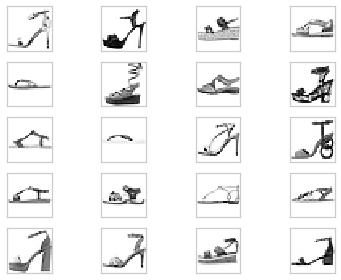

In [373]:
# Visualization of Different Sandals

fig, ax = plt.subplots(nrows=5, ncols=4, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(20):
    img = X_train[y_train == 5][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_9.png', dpi=300)
plt.show()

We can see that even the sandals vary in shape and category.  High heels look to be classified as sandals in this dataframe -- something my wife wholly disagrees with.  The wide variety of sandal category not only threw my wife off, which leads me to believe that our machine learning might struggle as well.    

### Multilayer Perceptron

In [374]:
# FIRST PASS WITH MLP

import numpy as np
from scipy.special import expit
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
      Number of output units, should be equal to the
      number of unique class labels.

    n_features : int
      Number of features (dimensions) in the target dataset.
      Should be equal to the number of columns in the X array.

    n_hidden : int (default: 30)
      Number of hidden units.

    l1 : float (default: 0.0)
      Lambda value for L1-regularization.
      No regularization if l1=0.0 (default)

    l2 : float (default: 0.0)
      Lambda value for L2-regularization.
      No regularization if l2=0.0 (default)

    epochs : int (default: 500)
      Number of passes over the training set.

    eta : float (default: 0.001)
      Learning rate.

    alpha : float (default: 0.0)
      Momentum constant. Factor multiplied with the
      gradient of the previous epoch t-1 to improve
      learning speed
      w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    
    decrease_const : float (default: 0.0)
      Decrease constant. Shrinks the learning rate
      after each epoch via eta / (1 + epoch*decrease_const)

    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent circles.

    minibatches : int (default: 1)
      Divides training data into k minibatches for efficiency.
      Normal gradient descent learning if k=1 (default).

    random_state : int (default: None)
      Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001, 
                 alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
          Input layer with original features.

        w1 : array, shape = [n_hidden_units, n_features]
          Weight matrix for input layer -> hidden layer.

        w2 : array, shape = [n_output_units, n_hidden_units]
          Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
          Input values with bias unit.

        z2 : array, shape = [n_hidden, n_samples]
          Net input of hidden layer.

        a2 : array, shape = [n_hidden+1, n_samples]
          Activation of hidden layer.

        z3 : array, shape = [n_output_units, n_samples]
          Net input of output layer.

        a3 : array, shape = [n_output_units, n_samples]
          Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        y_enc : array, shape = (n_labels, n_samples)
          one-hot encoded class labels.

        output : array, shape = [n_output_units, n_samples]
          Activation of the output layer (feedforward)

        w1 : array, shape = [n_hidden_units, n_features]
          Weight matrix for input layer -> hidden layer.

        w2 : array, shape = [n_output_units, n_hidden_units]
          Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
          Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
          Input values with bias unit.

        a2 : array, shape = [n_hidden+1, n_samples]
          Activation of hidden layer.

        a3 : array, shape = [n_output_units, n_samples]
          Activation of output layer.

        z2 : array, shape = [n_hidden, n_samples]
          Net input of hidden layer.

        y_enc : array, shape = (n_labels, n_samples)
          one-hot encoded class labels.

        w1 : array, shape = [n_hidden_units, n_features]
          Weight matrix for input layer -> hidden layer.

        w2 : array, shape = [n_output_units, n_hidden_units]
          Weight matrix for hidden layer -> output layer.

        Returns
        ---------

        grad1 : array, shape = [n_hidden_units, n_features]
          Gradient of the weight matrix w1.

        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
          Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
          Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    # FUNCTION FOR FITTING MLP 
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
          Input layer with original features.

        y : array, shape = [n_samples]
          Target class labels.

        print_progress : bool (default: False)
          Prints progress as the number of epochs
          to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):
            
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [375]:
#Learn some stuff
nnplay = NeuralNetMLP(n_output=10, 
                  n_features=X_train.shape[1], 
                  n_hidden=500, 
                  l2=0.1, 
                  l1=0.0, 
                  epochs=700, 
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  minibatches=50, 
                  shuffle=True,
                  random_state=1)

In [376]:
start = time.time()

history = nnplay.fit(X_train, y_train, print_progress=True)

end = time.time()
final_time = end-start
print(final_time)

Epoch: 1/700/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:206: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
Epoch: 700/700

1067.277244091034


We can see that the MLP took appox 17 mintues to run (1067 seconds) the 500 hidden layers with 700 epochs.  This took quite a long time, but it may prove to be worth it in accuracy.    

In [377]:
batches = np.array_split(range(len(nnplay.cost_)), 1000)
cost_ary = np.array(nnplay.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

#### Accuracy

In [378]:
import sys

y_train_pred = nnplay.predict(X_train)

if sys.version_info < (3, 0):
    acc = (np.sum(y_train == y_train_pred, axis=0)).astype('float') / X_train.shape[0]
else:
    acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 82.41%


In [379]:
y_test_pred = nnplay.predict(X_test)

if sys.version_info < (3, 0):
    acc = (np.sum(y_test == y_test_pred, axis=0)).astype('float') / X_test.shape[0]
else:
    acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 80.68%


####  The MLP was able to predict 82.41% within the training data and 80.68% for our test set.  
- This is honestly about as accurate as I would have been able to predict if I had tried to classify the pullovers vs coats vs shirts myself.  

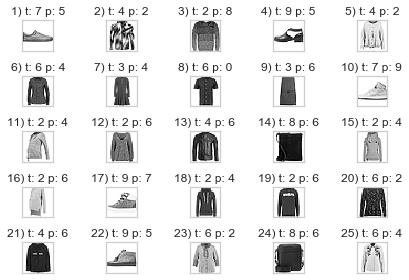

In [380]:
# What was missed!

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab= y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()

#### Labels: 
- 0 - T-shirt/top
- 1 - Trouser
- 2 - Pullover
- 3 - Dress
- 4 - Coat
- 5 - Sandals
- 6 - Shirt
- 7 - Sneaker
- 8 - Bag
- 9 - Ankle Boots
##### As we suspected, the tops and sandals are throwing off our MLP.  

#### Confusion Matrix

[[809   4  36  40   9   0  87   0  14   1]
 [  7 936  17  29   6   0   4   0   1   0]
 [ 11   1 559   9 288   0 128   0   3   1]
 [ 51   8  13 836  50   0  38   0   4   0]
 [  1   4  61  46 756   2 126   0   3   1]
 [  2   0   0   1   0 910   0  40   5  42]
 [191   3 109  27 130   1 522   0  17   0]
 [  0   0   0   0   0  37   0 908   0  55]
 [  4   1  26   8   8   4  41   5 901   2]
 [  0   0   1   0   0  17   0  49   2 931]]


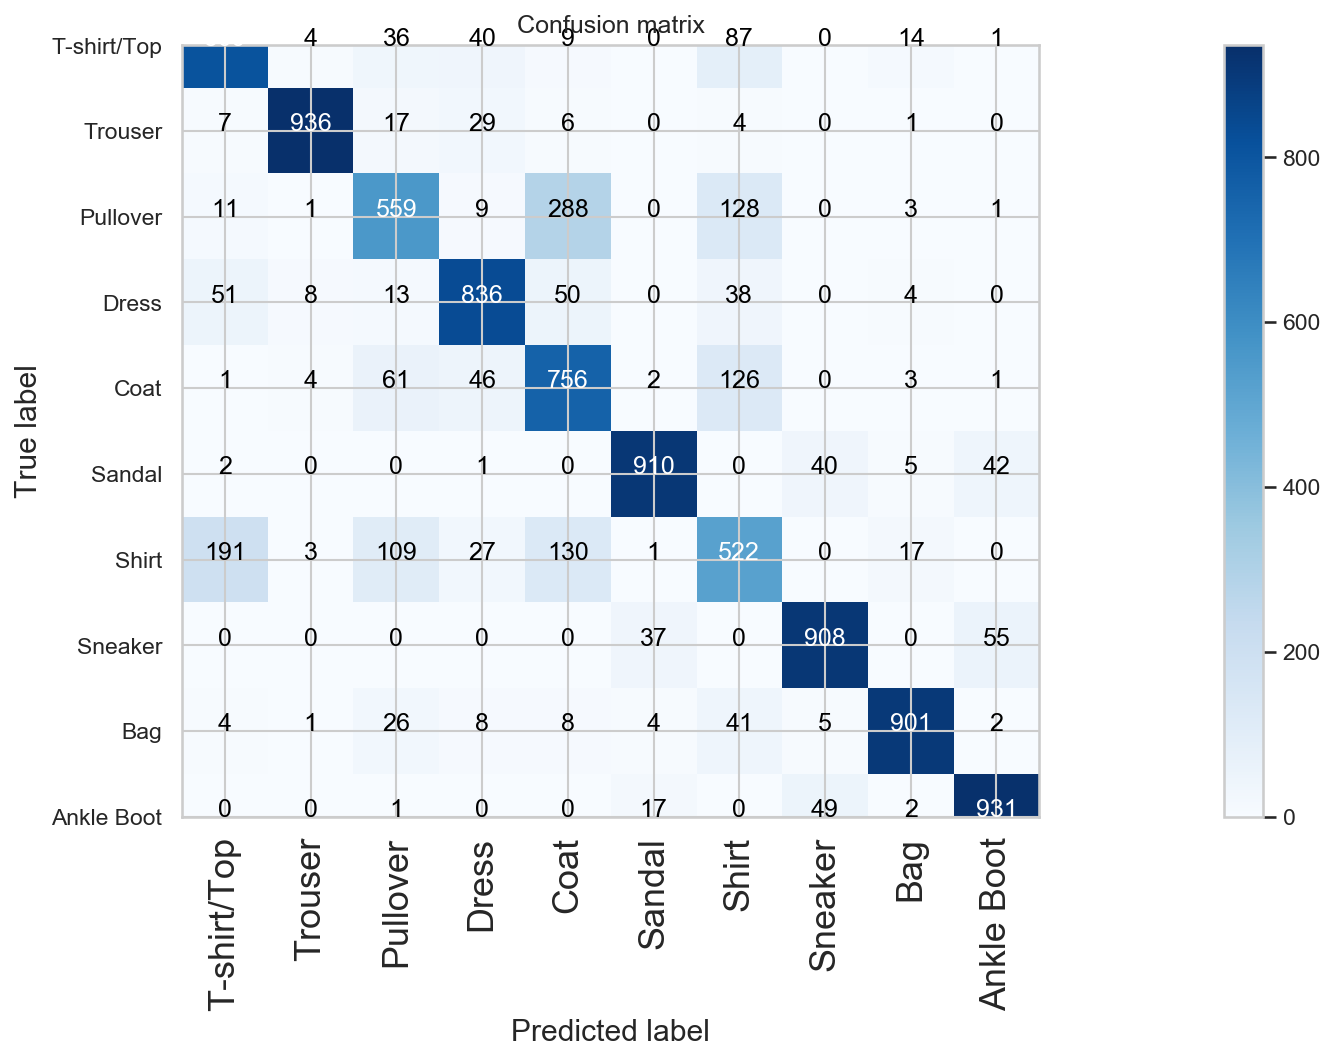

In [385]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)




expected = y_test
predicted = y_test_pred
print(sklearn.metrics.confusion_matrix(expected, predicted))
#plt.matshow(expected, predicted)

# compute the confusion matrix
confusion_mtx = confusion_matrix(expected, predicted) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

- Our confusion matrix further drives home that the tops are creating havoc in our prediction models -- particularly between the pullover vs coat.  We'll see if the Keras modeling can overcome this issue.  

### Keras

In [256]:
# BASIC WALK THROUGH FOR MNIST NN
# BASED ON KERAS TUTORIALS (2019)
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt

In [257]:
from keras.datasets import fashion_mnist


In [258]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


In [259]:
# SCRUB
# FLATTEN 28 x 28 IMAGE TO 784 VECTOR

num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [260]:
# SCRUB
# NORMALIZE INPUTS FROM RGB COLOR TO 0-1

X_train = X_train / 255
X_test = X_test / 255

In [261]:
# SCRUB
# THE OLD ONE HOT ENCODE - CONVERT "CATEGORICAL" CLASSIFICATION TO ENCODE
# A "BINARIZATION" OF THE CATEGORIES
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [262]:
# MODEL
# BUILD THE BASELINE

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [263]:
# MODEL
# RUN THE MODEL
start = time.time()


model = baseline_model()

# FIT THE MODEL

history  = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=1000, verbose=2)
end = time.time()
final_time = end-start
print(final_time)


# EVALUATE THE MODEL
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


Train on 60000 samples, validate on 10000 samples
Epoch 1/200
 - 1s - loss: 0.6896 - accuracy: 0.7638 - val_loss: 0.4941 - val_accuracy: 0.8277
Epoch 2/200
 - 1s - loss: 0.4309 - accuracy: 0.8529 - val_loss: 0.4354 - val_accuracy: 0.8468
Epoch 3/200
 - 1s - loss: 0.3939 - accuracy: 0.8622 - val_loss: 0.4189 - val_accuracy: 0.8514
Epoch 4/200
 - 1s - loss: 0.3564 - accuracy: 0.8764 - val_loss: 0.3918 - val_accuracy: 0.8600
Epoch 5/200
 - 1s - loss: 0.3377 - accuracy: 0.8805 - val_loss: 0.3716 - val_accuracy: 0.8676
Epoch 6/200
 - 1s - loss: 0.3185 - accuracy: 0.8878 - val_loss: 0.3812 - val_accuracy: 0.8614
Epoch 7/200
 - 1s - loss: 0.3073 - accuracy: 0.8908 - val_loss: 0.3567 - val_accuracy: 0.8758
Epoch 8/200
 - 1s - loss: 0.2907 - accuracy: 0.8963 - val_loss: 0.3469 - val_accuracy: 0.8799
Epoch 9/200
 - 1s - loss: 0.2806 - accuracy: 0.8994 - val_loss: 0.3390 - val_accuracy: 0.8787
Epoch 10/200
 - 1s - loss: 0.2675 - accuracy: 0.9051 - val_loss: 0.3374 - val_accuracy: 0.8807
Epoch 11/

Epoch 87/200
 - 1s - loss: 0.0349 - accuracy: 0.9902 - val_loss: 0.4180 - val_accuracy: 0.8987
Epoch 88/200
 - 1s - loss: 0.0329 - accuracy: 0.9908 - val_loss: 0.4287 - val_accuracy: 0.8955
Epoch 89/200
 - 1s - loss: 0.0310 - accuracy: 0.9915 - val_loss: 0.4267 - val_accuracy: 0.8993
Epoch 90/200
 - 1s - loss: 0.0334 - accuracy: 0.9902 - val_loss: 0.4271 - val_accuracy: 0.8980
Epoch 91/200
 - 1s - loss: 0.0286 - accuracy: 0.9922 - val_loss: 0.4148 - val_accuracy: 0.8989
Epoch 92/200
 - 1s - loss: 0.0295 - accuracy: 0.9922 - val_loss: 0.4246 - val_accuracy: 0.8991
Epoch 93/200
 - 1s - loss: 0.0247 - accuracy: 0.9943 - val_loss: 0.4250 - val_accuracy: 0.8991
Epoch 94/200
 - 1s - loss: 0.0248 - accuracy: 0.9938 - val_loss: 0.4239 - val_accuracy: 0.9005
Epoch 95/200
 - 1s - loss: 0.0267 - accuracy: 0.9928 - val_loss: 0.4238 - val_accuracy: 0.8981
Epoch 96/200
 - 1s - loss: 0.0229 - accuracy: 0.9947 - val_loss: 0.4342 - val_accuracy: 0.8978
Epoch 97/200
 - 1s - loss: 0.0225 - accuracy: 0.99

Epoch 173/200
 - 1s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5881 - val_accuracy: 0.9002
Epoch 174/200
 - 1s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5934 - val_accuracy: 0.9022
Epoch 175/200
 - 1s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.5967 - val_accuracy: 0.8998
Epoch 176/200
 - 1s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5937 - val_accuracy: 0.9017
Epoch 177/200
 - 1s - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.6130 - val_accuracy: 0.8977
Epoch 178/200
 - 1s - loss: 0.0552 - accuracy: 0.9815 - val_loss: 0.5772 - val_accuracy: 0.8888
Epoch 179/200
 - 1s - loss: 0.0480 - accuracy: 0.9825 - val_loss: 0.5946 - val_accuracy: 0.8949
Epoch 180/200
 - 1s - loss: 0.0319 - accuracy: 0.9888 - val_loss: 0.5753 - val_accuracy: 0.8963
Epoch 181/200
 - 1s - loss: 0.0127 - accuracy: 0.9970 - val_loss: 0.5758 - val_accuracy: 0.8998
Epoch 182/200
 - 1s - loss: 0.0056 - accuracy: 0.9994 - val_loss: 0.5792 - val_accuracy: 0.9007
Epoch 183/200
 - 1s - loss: 0.0035 - acc

In [265]:
score = model.evaluate(X_test, y_test)
print("Total Run Time:", final_time)
print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

10000/10000 [==============================] - 0s 21us/step
Total Run Time: 171.22767901420593
Loss: 0.6138
Accuracy: 0.9011


- After 200 epochs we were able to reach 90% accuracy of prediction for the fashion dataset.  This is slightly better than our MLP ran previously and quite a bit faster.  I did some research on the web and the most accurate I was able to find was 93% on kaggle.  Additionally, this model took less than 3 minutes to run!

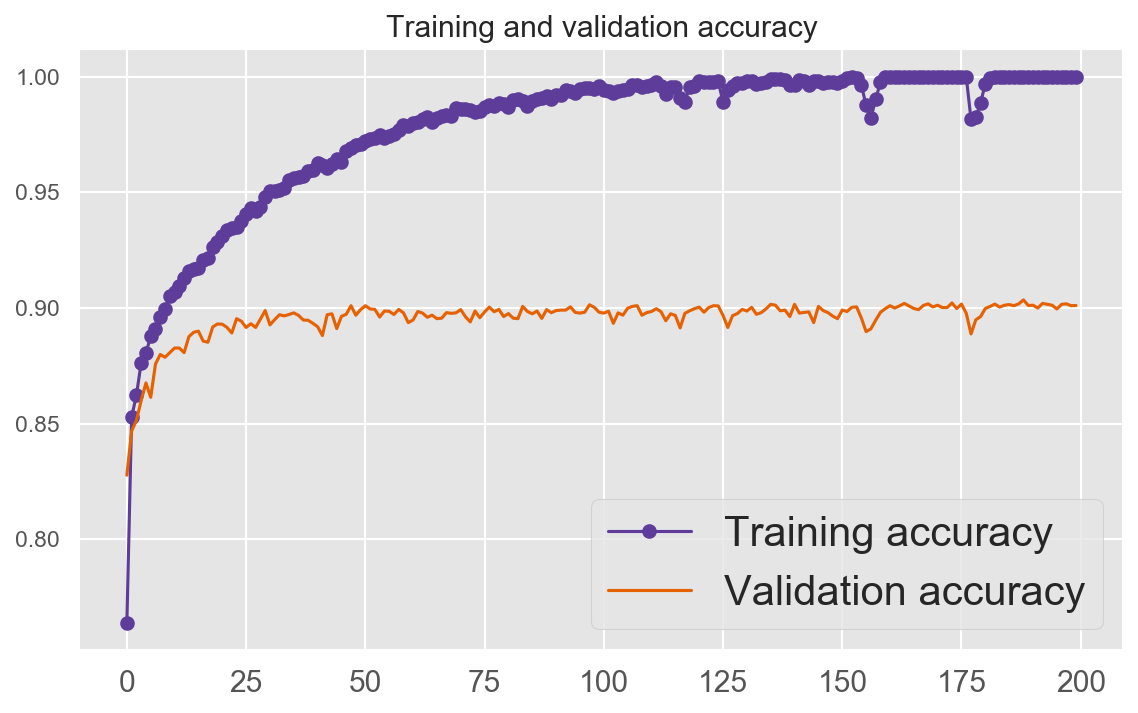

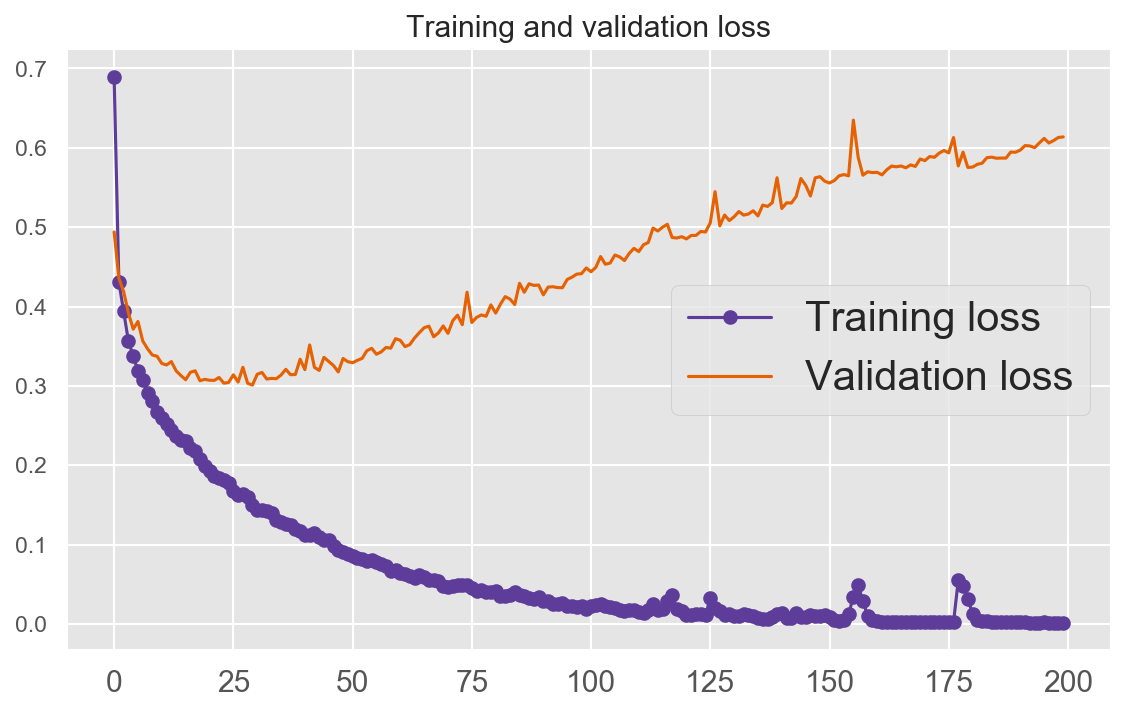

In [267]:
# INTERPRET 
# BUILD FUNCTION FOR PLOTTING THE RESULTS OF THE MODEL

def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, accuracy, marker='o', c=colors[3], label='Training accuracy')
        plt.plot(epochs, val_accuracy, c=colors[0], label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, loss, marker='o', c=colors[3], label='Training loss')
        plt.plot(epochs, val_loss, c=colors[0], label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
    
plot_train_curve(history)

- The validation loss is shown to increase over time while the training loss decreases.  This would suggest that there is likely some overfitting occuring between the 25-50 epoch mark.  It is difficult to train the MLP to have a high rate of accuracy without sacrificing some overfitting.  

#### Confusion Matrix

In [268]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

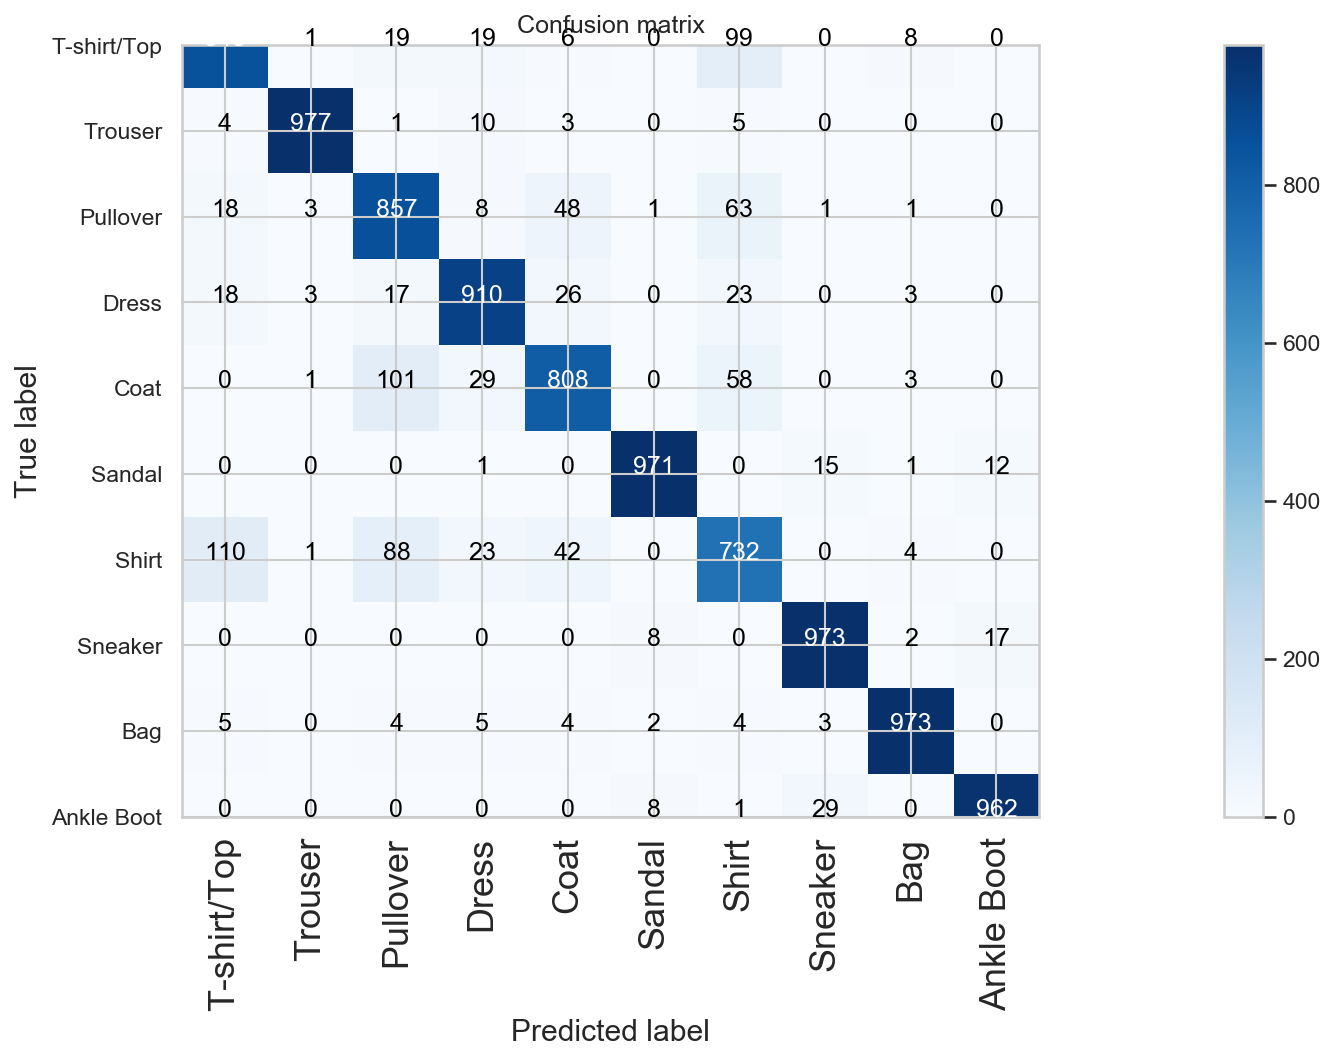

In [269]:
# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)


# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

- Again, we're losing on shirts vs top and pullover vs coats; however, the Keras model has predicted much more accurately at a much lower compute cost.  

### Naive Bayes

In [397]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score


In [398]:

ftest = pd.read_csv("fashion-mnist_test.csv")
ftrain = pd.read_csv("fashion-mnist_train.csv")

In [399]:
#ftest.head()

In [400]:
seed = 1 #set seed for reprod.
X = ftrain.iloc[:,1:] 
Y = ftrain.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [403]:
start = time.time() #measuring run time
gnb = GaussianNB() #NB model
model = gnb.fit(x_train, y_train) #Predict some things
end = time.time() #run time
final_time = end-start #final run time
print("Total time to run:", final_time)

Total time to run: 0.6676092147827148


In [404]:
preds = gnb.predict(x_test)#predict some things
#print(preds)

In [405]:
print(accuracy_score(y_test, preds)) #print accuracy

0.5854444444444444


In [406]:
# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [407]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

In [408]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[1087  122   65  305  134    1   23    0   41    0]
 [   3 1675   23   46    5    0   11    0    1    0]
 [   5   24  685  107  905    0   36    0   44    0]
 [   8  743   13 1011   63    0    9    0    6    0]
 [   1   62  100  251 1373    0    5    0   15    0]
 [   0    0    1    3    0  488    5 1251   17   43]
 [ 209   72  265  354  812    0   62    0   91    0]
 [   0    0    0    0    0   13    0 1693    1   23]
 [   1    4   79  167  245   10   24    5 1271    1]
 [   0    0    3    0    2   45    7  519   13 1193]]


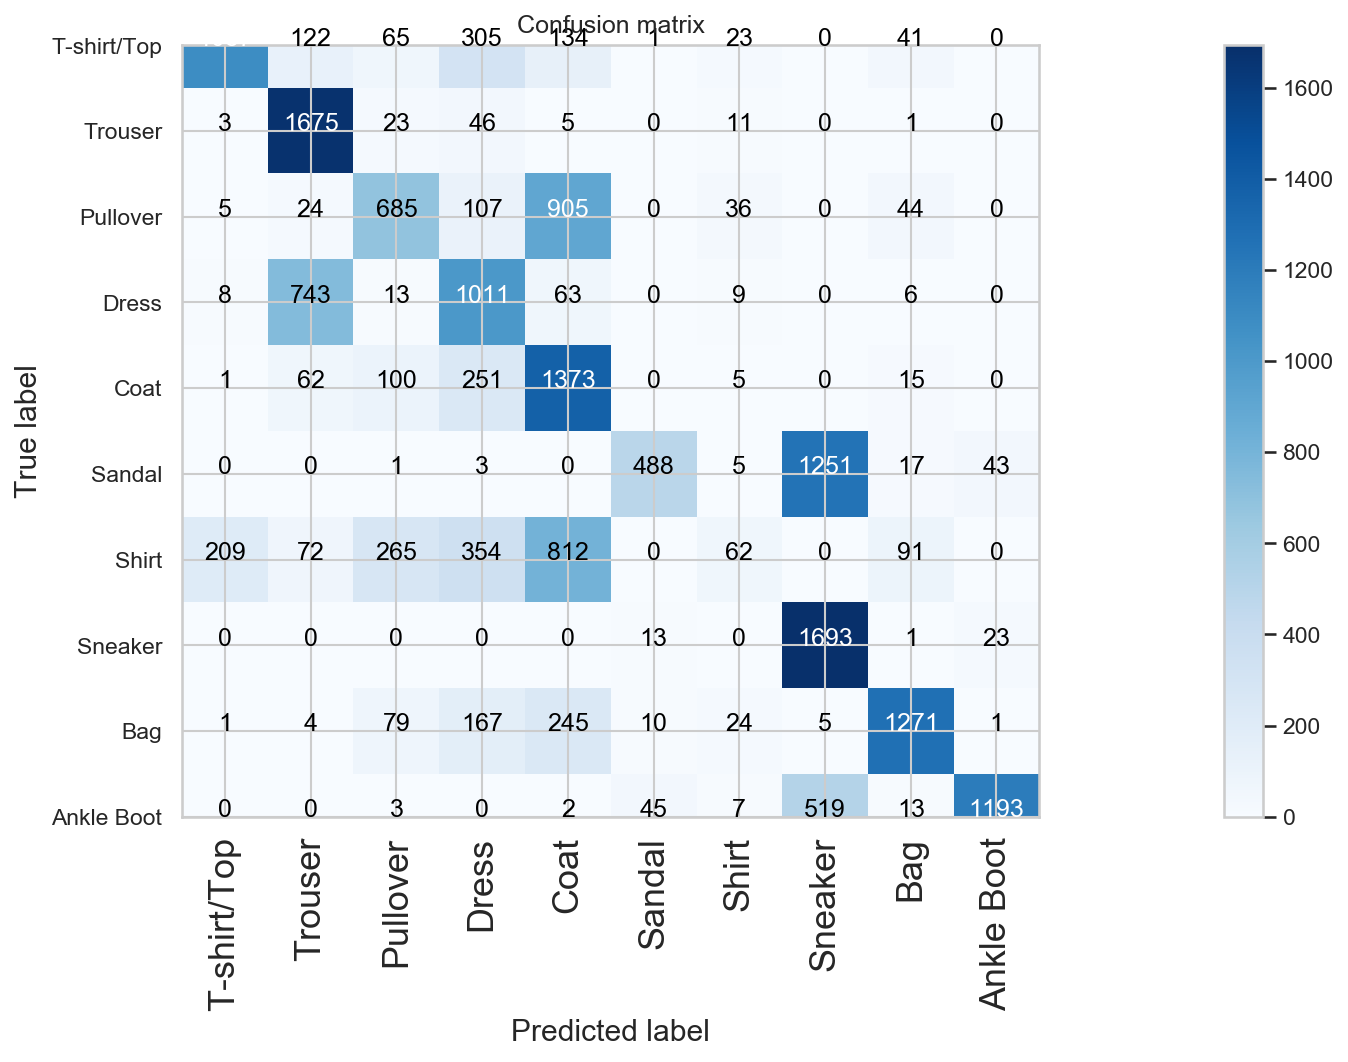

In [410]:
NBexpected = y_test
NBpredicted = preds
#print(sklearn.metrics.confusion_matrix(expected, predicted))
# Configure visualisations

#expected = y_test
#predicted = y_test_pred
print(sklearn.metrics.confusion_matrix(NBexpected, NBpredicted))
#plt.matshow(expected, predicted)

# compute the confusion matrix
confusion_mtx_NB = confusion_matrix(NBexpected, NBpredicted) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_NB, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])
#plt.ylim(0, 0)
#plt.show()

- Whelp, the Naive Bayes only performed with about 58.5% accuracy.  I believe the dataset is too complicated for Bayesian probabilities to predict with much accuracy. We can see that it is predicting pullover vs coat more than it is actually predicting pullovers.  We are also losing a lot on the sandal vs sneaker.  Naive Bayes does have one thing going for it, and that is time.  This model only took about half a second to run... if you want to incorrectly identify some clothing in a hurry, Naive Bayes is your go-to model.  

### Conclusion

In conclusion, the Keras model was our highest predictor at 90% with a decent runtime of about 3 minutes.  Our MLP model came in second at around 80%, but this took 17 minutes to complete.  Lastly, the Naive Bayes approach brought us the lowest accuracy of 58.5%; however this only took .60 seconds to run.  There are other approaches that may yield better results, but I believe the Keras is a very practical option for speed and accuracy.  One issue to be aware of with the Keras is the risk of overfitting the model on our training and test data.  

### References

Chinmay, Rane. "Fasion-MNIST-Accuracy-93%". kaggle, https://www.kaggle.com/fuzzywizard/fashion-mnist-cnn-keras-accuracy-93/notebook. Accessed 20 November 2019.

Halilovic, Inge. "Markdown for Jupityer notebooks cheatsheet". Medium, https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed. Accessed 3 December 2019. 

